In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Daten laden
df = pd.read_csv('raw_wetter_meteostat.csv')
df_leuchtturm = pd.read_csv('raw_wetter_leuchtturm_meteostat.csv')

# Konvertiere Datumsspalten in datetime-Format
df["date"] = pd.to_datetime(df["date"])
df_leuchtturm["date"] = pd.to_datetime(df_leuchtturm["date"])

Die Daten für die Sonnenscheindauer fehlen in "wetter_meteostat" ab 2019-05-05 (Wetterstation Kiel-Holtenau). Um keine missing values im Testzeitraum zu haben, fülle ich ab diesem Tag die Sonnenscheindauer mit den Werten von der Wetterstation Kiel-Leuchtturm auf.

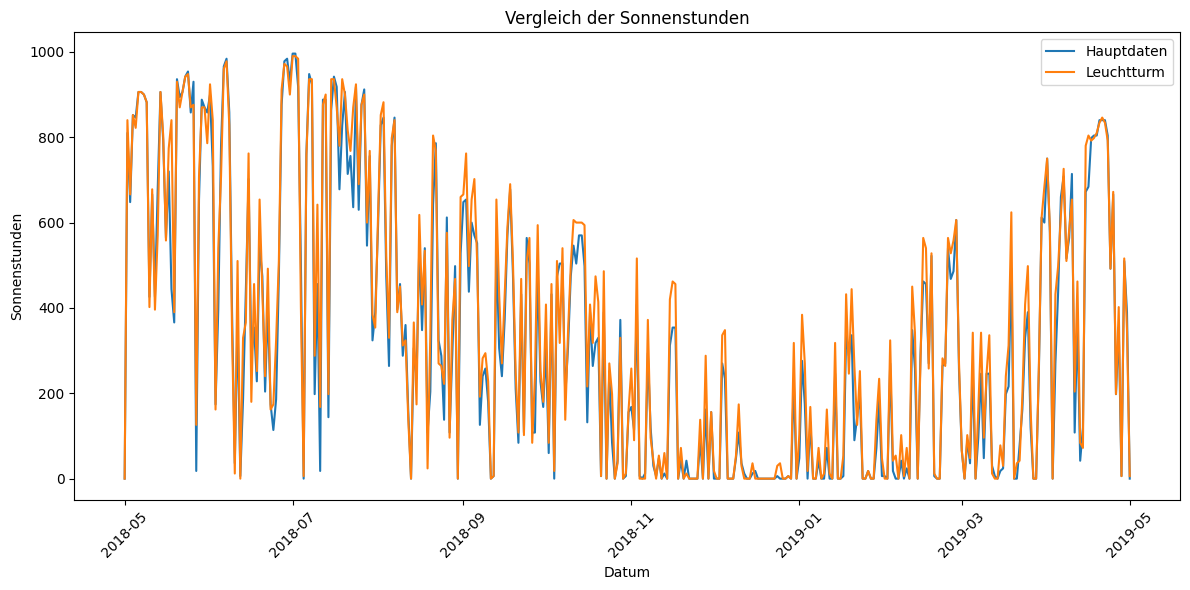

In [23]:
#Vergleich der Sonnenstunden der beiden Wetterstationen vom Vorjahr --> passt ziemlich gut

plt.figure(figsize=(12, 6))
df_filtered = df[(df_leuchtturm["date"] >= "2018-05-01") & (df["date"] <= "2019-05-01")]
df_leuchtturm_filtered = df_leuchtturm[(df_leuchtturm["date"] >= "2018-05-01") & (df_leuchtturm["date"] <= "2019-05-01")]
plt.plot(df_filtered["date"], df_filtered["tsun"], label="Hauptdaten")
plt.plot(df_leuchtturm_filtered["date"], df_leuchtturm_filtered["tsun"], label="Leuchtturm")
plt.xlabel("Datum")
plt.ylabel("Sonnenstunden")
plt.title("Vergleich der Sonnenstunden")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Zusammenführen der tsun-Daten ab dem 5.5.2019
df = pd.merge(df, df_leuchtturm, on="date", how="left", suffixes=("", "_leuchtturm"))

# Ersetzen von tsun mit tsun_leuchtturm, falls vorhanden
df.loc[df["date"] >= "2019-05-05", "tsun"] = df.loc[df["date"] >= "2019-05-05", "tsun_leuchtturm"]

# Entfernen der zusätzlichen Spalten von df_leuchtturm
columns_to_remove = [col for col in df.columns if col.endswith("_leuchtturm")]
df.drop(columns=columns_to_remove, inplace=True)

print(df.tail())

           date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  \
2217 2019-07-27  20.9  18.2  25.1   0.0   NaN   83.0  26.3  60.1  1010.1   
2218 2019-07-28  21.2  18.5  25.0   0.3   NaN   74.0  19.8  40.3  1005.6   
2219 2019-07-29  21.5  17.8  28.1   2.1   NaN   53.0  10.4  31.0  1009.7   
2220 2019-07-30  18.8  15.9  22.3   4.2   NaN  294.0   9.7  22.3  1012.2   
2221 2019-07-31  17.7  13.6  22.5   9.9   NaN  118.0   7.9  41.0  1014.7   

       tsun  
2217  786.0  
2218  660.0  
2219  630.0  
2220   18.0  
2221  126.0  


In [25]:
# Fehlende Werte
missing_values = df.isnull().sum()

# Unplausible Werte

def check_values(row):
    issues = []

    # Temperatur Checks
    if not (-100 <= row["tavg"] <= 60):
        issues.append("tavg unplausible")
    if not (-100 <= row["tmin"] <= 60):
        issues.append("tmin unplausible")
    if not (-100 <= row["tmax"] <= 60):
        issues.append("tmax unplausible")
    if row["tmax"] < row["tmin"]:
        issues.append("tmax < tmin")
    if not (row["tmin"] <= row["tavg"] <= row["tmax"]):
        issues.append("tavg not between tmin and tmax")

    # Niederschlag und Schnee Checks
    if row["prcp"] < 0:
        issues.append("negative prcp")
    if row["snow"] < 0:
        issues.append("negative snow")

    # Wind Checks
    if row["wspd"] < 0:
        issues.append("negative wspd")
    if row["wpgt"] < 0:
        issues.append("negative wpgt")

    # Druck Checks
    if not (870 <= row["pres"] <= 1085):
        issues.append("pressure out of range")

    return issues

# Anwenden der Checks
df["issues"] = df.apply(check_values, axis=1)

# Nur Zeilen mit unplausiblen Werten ausgeben
unplausible_rows = df[df["issues"].apply(lambda x: len(x) > 0)]

# Ergebnisse anzeigen
print("Fehlende Werte pro Spalte:")
print(missing_values)
print("\nUnplausible Werte:")
print(unplausible_rows[["date", "issues"]])


Fehlende Werte pro Spalte:
date       0
tavg       0
tmin       0
tmax       0
prcp       0
snow    1014
wdir       1
wspd       1
wpgt       0
pres       1
tsun       0
dtype: int64

Unplausible Werte:
           date                   issues
1582 2017-10-30  [pressure out of range]


In [26]:
# Spalte "wetter_sehr_schön" erstellen
df["wetter_sehr_schön"] = (
    (df["tavg"] >= 18) & (df["tavg"] <= 25) &  # Durchschnittstemperatur
    (df["prcp"] <= 0.1) &                      # so gut wie kein Niederschlag
    (df["wspd"] < 15) &                        # Windgeschwindigkeit
    (df["tsun"] > 300)                         # Sonnenscheindauer
).astype(int)

# Spalte "wetter_sehr_schlecht" erstellen
df["wetter_sehr_schlecht"] = (
    (df["tavg"] < 0) | (df["tavg"] > 30) |     # Sehr kalt oder sehr heiß
    (df["prcp"] > 6) |                         # Starker Niederschlag
    (df["wspd"] > 30)                          # Starker Wind
).astype(int)

# Ergebnis speichern
df = df[["date", "wetter_sehr_schön", "wetter_sehr_schlecht"]]
df.to_csv("wettercode_ersatz.csv", index=False)

# Vorschau der neuen Spalten
print(df[["date", "wetter_sehr_schön", "wetter_sehr_schlecht"]].head())

# Anzahl der Schönwetter- und Schlechtwettertage berechnen
anzahl_schönwettertage = df["wetter_sehr_schön"].sum()
anzahl_schlechtwettertage = df["wetter_sehr_schlecht"].sum()
print(len(df))

# Ergebnisse ausgeben
print(f"Anzahl der Schönwettertage: {anzahl_schönwettertage}")
print(f"Anzahl der Schlechtwettertage: {anzahl_schlechtwettertage}")

        date  wetter_sehr_schön  wetter_sehr_schlecht
0 2013-07-01                  0                     0
1 2013-07-02                  0                     0
2 2013-07-03                  0                     1
3 2013-07-04                  0                     0
4 2013-07-05                  0                     0
2222
Anzahl der Schönwettertage: 131
Anzahl der Schlechtwettertage: 373
